# Session 2 - Running a cosmological simulation

In the first session we have ran a simple, idealised simulation of the merger of two NFW haloes. In this next session the aim is to now run a full cosmological volume that simulates the growth of structure from the early univers (z ~ 100) through to today. By the end of the session you will hopefully have achieved the following:

- Learned about Gaussian random fields, and how these describe the ICs
- Genereated cosmological ICs for a Planck cosmology
- Ran the comslogic N-body simulation

We will being by importing the modules used throghtout this notebook.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

## Gaussian random fields, and the power spectrum

When we observe the cosmic microwave background (CMB) the temperatuere fluctuation, and correpsnig density fluctuations, resemble that of a Gaussian random field. As such, we need to use and understand Guassian random fields to generate the inital conditions for our simulation.

In what follows we will focus on a 2D random field, for simpicity, but the simulations we will run shortly will be in 3D.

Let's begin by generating the simlist form of a Guassian random field. One where there is no spatial correlation between the different fluctuations what is known as a white noise field, and each 'pixel' is independently drawn from a Guasain probability.

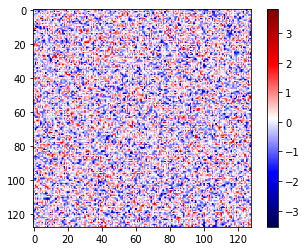

In [2]:
N=128
sigma = np.random.normal(loc=0,scale=1,size=(N,N))

plt.imshow(sigma,cmap='seismic')
plt.colorbar()

In this example we should think of this as mapping to the overdensity field. Here we see that some regions are underdense (negative values) and some are overdense (positive). To describe the statistically averaged form of the density fluctuations it is common to plot the power spectrum of the field. This is essentially just the Fourier transform of the overdensity field.

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


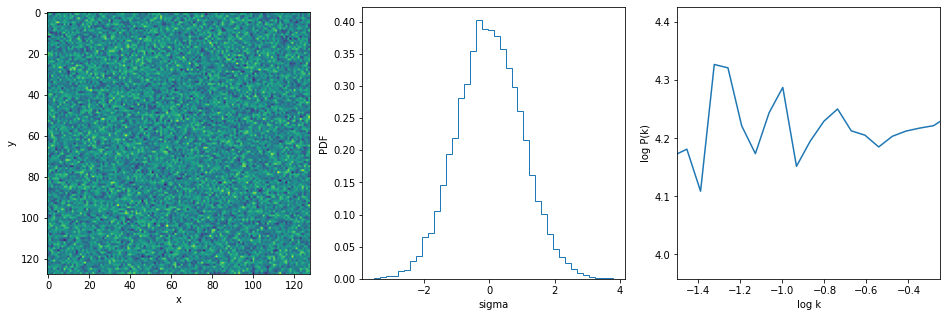

In [3]:
# define a function to plot the density field, the 1d histogram, and the power spectrum
def field_plot(sigma,ft_bins = 30, hist_bins = 40):
    N=sigma.shape[0]
    #calculate ft and power spectrum
    ft = np.fft.fft2(sigma)
    ft_p = np.abs(ft)**2
    
    k_1d = np.fft.fftfreq(N)
    kx,ky = np.meshgrid(k_1d,k_1d)
    k = (kx**2+ky**2)**0.5
    k_log = np.log10(k.flatten())
    
    #bin data
    pk,k_bins,_ = stats.binned_statistic(k_log[1:],ft_p.flatten()[1:],statistic='mean',bins=ft_bins) #[1:] to ignore k=0
    
    #now plot
    fig, ax = plt.subplots(1,3,figsize=(16,5))
    
    ax[0].imshow(sigma)
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    
    ax[1].hist(sigma.flatten(),bins = hist_bins,histtype='step',density=True)
    ax[1].set_ylabel('PDF')
    ax[1].set_xlabel('sigma')
    
    ax[2].plot(k_bins[1:],np.log10(pk))
    ax[2].set_xlabel('log k')
    ax[2].set_ylabel('log P(k)')
    ax[2].set_xlim(-1.5,-0.25)
    
    return(fig,ax)

_ = field_plot(sigma)

Here we again see the density field on the left. The middle panel shows the histogram of all overdensities, ignoring any spatial information. Here the population is clearly sampled from a Guassian distribution, hence the 'Gaussain' random field. 

On the right is plotted the power spectrum for this partcualr random field. On the x axis is the Fourier mode, where $k^2 = k_x^2 + k_y^2$, while on the y axis is the mean amplitude of the fourier modes at the given k-scale. In general the power spectrum describes the size of the density fluctuations at the given scale (remember, small k mean large physical scale, and vice versa). In this particular example $P(k) = const$, telling us that there is no spatial correlation in the field, exactly what is expected for a white noise field.

$P(k)$ is not only a useful way of summarising the information contained within the 2D (or later 3D) density field, but actually completely desribes the field in a statistiscally way. Hence, by specifiying or measuring $P(k)$ we have all of the informaiton about the whole field.

Let's have a look at an example of where there is some structure in the overdenisty Gaussain field. We will specifically look at the case where $P(k) \propto k^{-3}$, whcih is close to what we observe in our own universe.

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in multiply
  # Remove the CWD from sys.path while we load stuff.
/cosma/local/Python/3.6.5/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


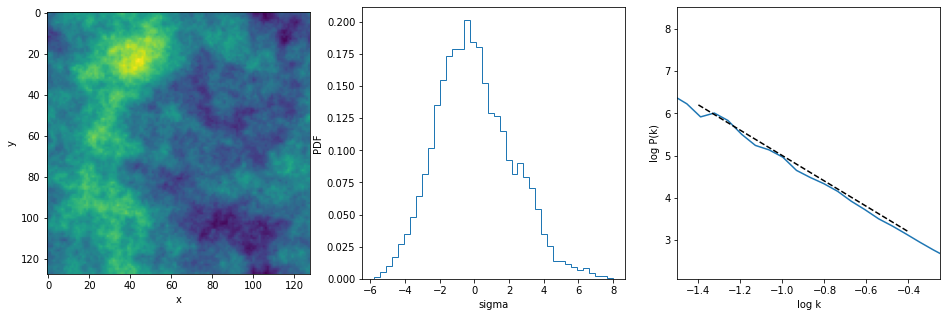

In [4]:
#adjust power spectrum
slope = -3
k_pivot = 10**(-0.8)

ft = np.fft.fft2(sigma)

k_1d = np.fft.fftfreq(N)
kx,ky = np.meshgrid(k_1d,k_1d)
k = (kx**2+ky**2)**0.5
ft_2 = ft*(k/k_pivot)**(slope/2)
ft_2[0,0] = ft[0,0]
sigma_2 = np.fft.ifft2(ft_2)

#plt.imshow(np.real(sigma_2))

fig,ax = field_plot(np.real(sigma_2))

k=np.linspace(-1.4,-0.4,100)
ax[2].plot(k,slope*k+2,'k--')

Here there is now clear structure in the left panel, whith large regions of over and underdensities, and generally strucutres at all scales. The power spectrum on the right also shows the $P(k) \propto k^{-3}$ dependence. Have a mess around with the input power spectrum and see what the effect is on the denisty field.

## Initial conditions

First let's decide on the specific cosmology we want to simulate. Here, we are going to simulate a $\Lambda$CDM cosmology with the Plack 2018 inferred paramters. Specifically, this is:

- $h=0.67321$, the hubble paramter where the Hubble constant is $H_{0} = 100$ $h$ km s$^{-1}$ Mpc$^{-1}$
- $\Omega_m = 0.3158$, ratio of matter
- $\Omega_{\Lambda} = 0.6842$, ratio of dark energy (note $\Lambda$CDM is flat so $\Omega_m + \Omega_{\Lambda} = 1$)
- $\Omega_b = 0.0494$, ratio of baryons 
- $n_s = 0.9661$, the scalr spectral index whih controls the slope of the power spectrum
- $A_s = 2.1488 \times 10^{-9}$, the spectral amplitude whihc controls the amplitude of the power spectrum
- $\sigma_8 = 0.8102$, another measure of the amplitude of the power spectrum that is often quoted instead of $A_s$ (you only need either $A_s$ or $\sigma_8$)

The first thing we need is then the power spectra for the given cosmology we want to simulate, and will in general dpeend on all of the above parameters. There are a range of codes available to generate the linear power spectrum for a $\Lambda$CDM cosmology, here we will use [CAMB](https://camb.readthedocs.io/en/latest/), and have already generated both the power spectrum and transfer function (needed later) for you.

Let's have a quick look at the power spectrum for this cosmology at the redshift we are going to generate the ICs ($z=127$)

Text(0, 0.5, '$P(k)$')

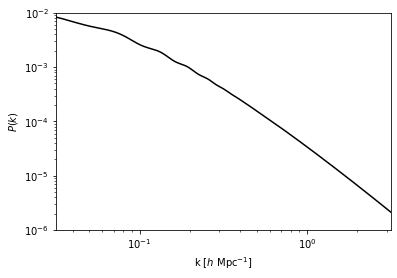

In [5]:
pk = np.loadtxt('../ICs/L025N064_DMONLY/input_powerspec.txt')
x_sample = np.array([10**-0.5,2])
plt.plot(pk[:,0],pk[:,1],'k-')
plt.xscale('log')
plt.yscale('log')
plt.xlim(10**-1.5,10**0.5)
plt.ylim(10**-6,10**-2)
plt.xlabel('k [$h$ Mpc$^{-1}$]')
plt.ylabel('$P(k)$')

The form of the power spectum on the right is close to that of the power spectrum we looked at before, so the density fluctuations will be similar in form. However the power spectrum is not as simple as a pure power law for a $\Lambda$CDM cosmology. It is overall a smoothly varying power law, getting steeper at large k values. And it additionally has 'wiggles' corresponding to the Baryon Acoustic Oscicallations (BAO).

Now that we have the power spectrum we wish to use to generate the ICs we need to generate the corresponding density field. The general process is the same as discussed above in the 'Gaussain field' section. We start with a whit noise field, and then map this to the particular power spectrum we want. However, what we need to run the simualtions, whcih are gravitional N-body simuations, is not a denisty field but particle positions. To convert from $\sigma (x)$ to a collection of particle positions it is most common to use the Zeldovich approximation, or higher order equvalents such as second order lagrangian perturbation theory (2LPT). 

As with generating the power spectrum there are various codes available that will generate the ICs for you, taking care of all the details that are important. Here we are going to use [MUSIC](https://www-n.oca.eu/ohahn/MUSIC/). While this software is primarilly developed to create zoom-in initail conditions (something not covered in this summer school) it works well to generate cosmological volumes, that we want to run.

With the MUSIC code compiled we can now generate out initial conditions. Everything you need should be in the ICs folder. This includes a camb transfer function `transfer_camb_planck_z127.0.txt` and a MUSIC paramter file `ics_planck.conf`. Now simply run`./MUSIC ics_planck.conf`, in the ICs directory. Have a quick look through the paratmers file that is going to set a few of the propoerties of the simulation we're going to run. Two of the import paramters are the boxlength and level_min; in this case we're running a box of length $50$ $h^{-1}$ Mpc with $2^7 = 128$ particles per dimesion (so in total $2^{7+3} = 1024$ particles).

Hopefully, this runs without an issue. And will dump a bunch of files, where the most important one will be ICs file called `ics_gadget.dat`. This is a gadget binary file, so it is not human readable, but will be able to be used with swift.

Before running the simulation let's check that everything looks alright by double checking that the power spectrum is input. You can calcualte the power spectrum of the ICs using *GenPK*. Try the following
```
gen-pk -i ics_gadget.dat -o ./

```

This should output a file that `PK-DM-*`. We can now compare this to the power spectrum we wanted, for wich we will use the file `input_powerspec.txt` output by MUSIC.

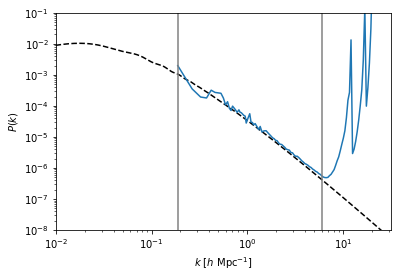

In [6]:
N = 64 #number of particel per dimension
boxsize = 50 #boxsize

h = 0.669
pk_lin = np.loadtxt('../ICs/L025N064_DMONLY/input_powerspec.txt')
pk_sim = np.loadtxt('/cosma/home/dp004/dc-brow5/Python_Code/Summer_school/ICs/L025N064_DMONLY/PK-DM-ics_gadget.hdf5')

pk_sim[:,0] *= 2*np.pi/boxsize /h
pk_sim[:,1] *= boxsize**3/(2*np.pi)**3 *h**3
         

plt.figure()
plt.plot(pk_lin[:,0],pk_lin[:,1],'k--',label='Linear pk')
plt.plot(pk_sim[:,0],pk_sim[:,1],label='ICs')
#let's also plot the fundametal mode and the nyquist frequncy
k_fund = 2*np.pi/boxsize /h
k_nyq = (np.pi*N/boxsize /h)
plt.plot(np.ones(2)*k_fund,np.array([10**-8,10**-1]),color='gray')
plt.plot(np.ones(2)*k_nyq,np.array([10**-8,10**-1]),color='gray')
plt.xscale('log')
plt.yscale('log')

plt.xlim(10**-2,10**1.5)
plt.ylim(10**-8,10**-1)
plt.xlabel('$k$ [$h$ Mpc$^{-1}$]')
plt.ylabel('$P(k)$')
plt.show()

Overall the match between the measured power spectrum (blue) and the specified one (black dashed) is good. There are two key k-scales to keep in mind here, both related to the size and resolution of the simulation. The first is the fundamental, $k_{f} = 2 \pi /L$, that is the largest fourier mode that can fit in the box. Any k-values below this are not sampled, additionally small k-values near $k_f$ will be very susceptible to comsic variance, as can be seen by the random deviation from the dashed black line at low k. The other importnat k-sacle is the Nyquist frequency, $k_{nyq} = \pi N/L$. This is the smallest scale that can be sampled for the given resoltuion. Aything below this is effectively not resolved, and the measured power spectrum deviated strgongly from the input in the input.

Increasing either the box size or number of particle, $L$ or $N$, leads to a wider range of the power specrum to be sampled. However, it is computationally expensive to simuate large voluems at high resolution, so in practice it is not possible to increase $L$ and $N$ to arbitrarilly large values. The optimal resolution and boxsize depends strongly on the given scientific question, and therefore has no easy answer. Here we use $L=25$ and $N=2^6=64$ to be able to run a quick simulation.

## Running the simulation

With the IC generated we can now run the simulation. The basic process is the same as session 1, however we're now running a different kind of simulation so will need slightly different configuration and paramter files. Everything you need to should be set up in the `./simulation` folder of this session's directory.

Let's first look at the submission script that should lok like the following:

```
#!/bin/bash -l

./swift --cosmology --self-gravity --power --threads=16 parameter_cosmo.yml
```

The two additional flags added compared to the first session are `--cosmology` and `--power`. The first spedifies that this is a cosmological run, while the second turn on the ability for swift to calcualte the power spectra on the fly, dumping them alongside the snapshots. We have also now got a new paramter file `parameter_cosmo.yml`, that contains all the additional parameters need. This is mainly just the cosmological paramters and properties about the power spectra calculations.

Let's now run the simulation by typing `./submit.sh`. This will take a little while to run, probably 5-10 minutes. Hopefully, this finishes without issue.

Let's have a first look at the simulations by looking at the particle distribtion. We will now also use the `swiftsim_io` package that makes interfacing with and analysing seift outputs striahgforward and efficient.

Let's start by chceking some of the bosix properties of the simuation, and looking at the particle simuatlison

In [7]:
import swiftsimio as sw

data = sw.load("./simulation/output/snap_0062.hdf5") #read final snapshot

#check boxsize, particle number, and redhshift

print('Boxsize:')
print(data.metadata.boxsize)

print('Particle numbers:')
print(data.metadata.n_dark_matter)

print('Redshift:')
print(data.metadata.redshift)

Could not find gas gamma, assuming 5./3.
Boxsize:
[37.13551494 37.13551494 37.13551494] Mpc
Particle numbers:
262144
Redshift:
2.220446049250313e-16


Great, we can see that the boxsize is $50$ $h^{-1}$Mpc $\approx$ $37$ Mpc, there are $2^{6 \times 3}=262144$ particles, and the final snapshot is $z=0$. Now let's read in the particle positions.

(0.0, 37.13551493898175)

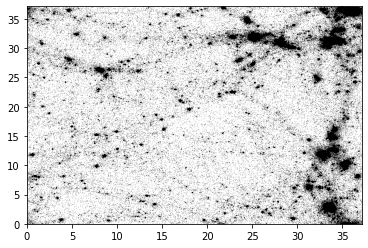

In [8]:
pos = data.dark_matter.coordinates

plt.plot(pos[:,0],pos[:,1],'k.',markersize=0.25,alpha=0.2)
plt.xlim(0,data.metadata.boxsize[0])
plt.ylim(0,data.metadata.boxsize[0])

Here we see the formation of structures in the simulation. In particular we can see very dense collapse, roughly spherical, objects that we refer to as DM haloes. We can also begin to see the strusture of the cosmic web, where matter tends to fall into DM haloes along filamatry structure.

Will plotting the particle posisitons as a scatter plot gives us an idea of the strusture, it is often better to visualtise the distribution by clauitng and plotting the surface density. `swiftsim_io` includes a few tools to help us do this, and make a better (and prettier) visualisation of our simulation.

/cosma/local/Python/3.6.5/lib/python3.6/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


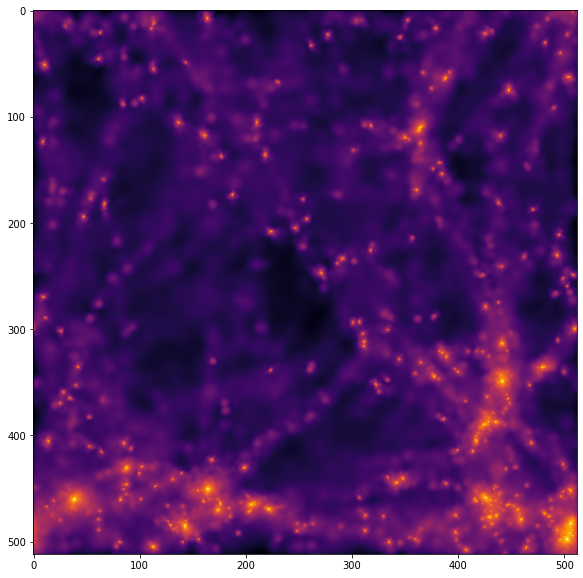

In [9]:
from swiftsimio.visualisation.projection import project_pixel_grid
from swiftsimio.visualisation.smoothing_length_generation import generate_smoothing_lengths

data.dark_matter.smoothing_length = generate_smoothing_lengths(
    data.dark_matter.coordinates,
    data.metadata.boxsize,
    kernel_gamma=1.8,
    neighbours=57,
    speedup_fac=1,
    dimension=3,
)

dm_mass = project_pixel_grid(data=data.dark_matter,boxsize=data.metadata.boxsize,resolution=512,project="masses",parallel=True,region=None)
vmin=np.min(np.log(dm_mass))
vmax=np.max(np.log(dm_mass))

fig=plt.figure(figsize=(10,10))
plt.imshow(np.log(dm_mass),cmap='inferno')

The strusture witihn th esimuatlion is now much clearer, where both the individual haloes and comsoic web can clearly be seen.

Let's now look at the redshift evolution of the structure, where we can observe the growth of structure over time.

Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.


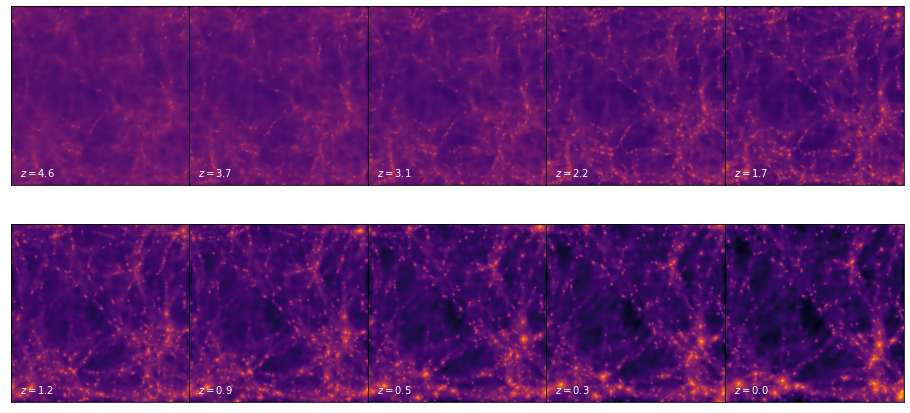

In [10]:
n_plot = 10
n_cols = 5
n_row = n_plot//n_cols + (n_plot%n_cols >0)

min_snap = 40
max_snap = 62

snap_numbers = np.linspace(min_snap,max_snap,n_plot)

fig,ax = plt.subplots(n_row,n_cols,figsize=(16,8))

k=0
for i in range(n_row):
    for j in range(n_cols):
        
        data = sw.load('./simulation/output/snap_%04d.hdf5'%(int(snap_numbers[k])))
        data.dark_matter.smoothing_length = generate_smoothing_lengths(data.dark_matter.coordinates,data.metadata.boxsize,kernel_gamma=1.8,neighbours=57,speedup_fac=1,dimension=3)
        dm_mass = project_pixel_grid(data=data.dark_matter,boxsize=data.metadata.boxsize,resolution=512,project="masses",parallel=True,region=None)
        
        ax[i,j].imshow(np.log(dm_mass),cmap='inferno',vmin=vmin,vmax=vmax)
        
        ax[i,j].text(0.05,0.05,'$z=%.1f$'%data.metadata.redshift,color='white',transform=ax[i,j].transAxes)
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        k+=1
plt.subplots_adjust(wspace=0, hspace=0)


Here the evolution of structure is clear. The universe starts in a relatively smooth state (here at $z \sim 4$) before strucutere continue to grow and collpase, particualrly you can see the merger of the different strucutres. This results in both the oversensties becoming denser (more red in the colormap), as well as the underdensities becoming more undersdens (moreblack in the colormap).

We can be a bit more quantitative in describgin the volution of strucutre by looking at the evolution of the power spectrum over time.


Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.
Could not find gas gamma, assuming 5./3.


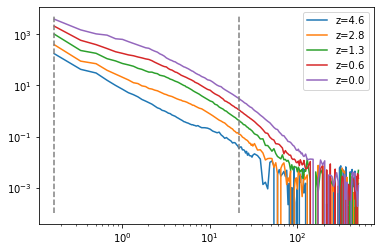

In [11]:
boxsize=25/h
N=64
k_fund = 2*np.pi/boxsize
k_nyq = (np.pi*N/boxsize)

n_plot = 5
min_snap = 40
max_snap = 62
snap_numbers = np.linspace(min_snap,max_snap,n_plot)

#plot power spectra
z = []
plt.figure()
for i in range(n_plot):
    data = sw.load('./simulation/output/snap_%04d.hdf5'%(int(snap_numbers[i])))
    pk = np.loadtxt('./simulation/power_spectra/power_matter_%04d.txt'%int(snap_numbers[i]))
    plt.plot(pk[:,1],pk[:,2],label='z=%.1f'%data.metadata.redshift)
    
    z.append(data.metadata.redshift)
    
#plot fundament and nyquist frequencies
plt.plot(np.ones(2)*k_fund,[10**-4,10**3.7],'--',color='gray')
plt.plot(np.ones(2)*k_nyq*4,[10**-4,10**3.7],'--',color='gray') #multiplied by 4 due to the 'folding'

plt.xscale('log')
plt.yscale('log')
plt.legend()


It's also useful to look at this compared to theoretical expectation. In particular it is useful to compare to the prediction form linear perturbation theory. Here we are going to use CAMB to generate the predcition for the linear $P(k)$, though there are multiple codes out there that can do this for you.